# Dataset evaluation

In [18]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd

from collections import OrderedDict
import torch
from sklearn.metrics import accuracy_score, classification_report

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from tqdm import tqdm
from pathlib import Path

datafolder = Path("../../Data")

In [19]:
import torch
import clip
from PIL import Image
import onnx
from onnx import helper


vision_arch = "RN50x4"
device = "cuda" if torch.cuda.is_available() else "cpu"

model, preprocess = clip.load(vision_arch, device=device)

## From Lia
# define text prompts
names2 = ["architectural","office", "residential", "school", "manufacturing",  "cellar", "laboratory","construction site", "mining", "tunnel"]
names3 = ["construction site", "town","city", "country side","alley","parking lot", "forest"]

# 5 sentences to use as text prompt
prompts = [
    "a photo of a {}.",
    "a picture of a {}.",
    "an image of a {}.",
    "a {} scene.",
    "a picture showing a scene of a {}."
]
sent2 = [prompt.format(label) for label in names2 for prompt in prompts]
sent3 = [prompt.format(label) for label in names3 for prompt in prompts]

# tokenize text prompts
text1 = clip.tokenize(["indoor", "outdoor"]).to(device)
text2 = clip.tokenize(names2).to(device)
text3 = clip.tokenize(names3).to(device)

In [20]:
'''
Function that calculates the probability that each image belongs to each class
In: path of the image folder, tokenized text prompts 
Out: dataframe with the probability scores for each image
'''
def get_pred(input_folder, text1, text2, text3):

    # List all files in the input folder
    files = os.listdir(input_folder)

    in_list = []
    out_list = []
    in_arch_list = []
    in_constr_list = []
    out_constr_list = []
    out_urb_list = []
    out_for_list = []
    scene_list = []
    img_list = []
    # Loop through each file
    for file in tqdm(files,desc="Files"):
        # Read the image
        image_path = os.path.join(input_folder, file)
        image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

        ### FIRST DEGREE ###
        text = text1
        with torch.no_grad():
            
            logits_per_image, logits_per_text = model(image, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()

        score_in = probs[0][0]
        score_out = probs[0][1]

        ### SECOND DEGREE (in) ###
        text = text2
        with torch.no_grad():

            logits_per_image, logits_per_text = model(image, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()
            # uncomment when processing 5 sentences
            #new_size = arr.shape[1] // 5
            #reshaped_arr = np.array([arr[0, i:i+5].sum() for i in range(0, arr.shape[1], 5)]).reshape(1, new_size)

        score_in_arch = (probs[0][0] + probs[0][1] + probs[0][2] + probs[0][3] + probs[0][4] + probs[0][5] + probs[0][6]) 
        score_in_constr = (probs[0][7] + probs[0][8] + probs[0][9]) 

        ### SECOND DEGREE (out) ###
        text = text3
        with torch.no_grad():
            
            logits_per_image, logits_per_text = model(image, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()
            # uncomment when processing 5 sentences
            #new_size = arr.shape[1] // 5
            #reshaped_arr = np.array([arr[0, i:i+5].sum() for i in range(0, arr.shape[1], 5)]).reshape(1, new_size)

        score_out_constr = probs[0][0] 
        score_out_urb = (probs[0][1] + probs[0][2] + probs[0][3] + probs[0][4] + probs[0][5]) 
        score_out_for = probs[0][6] 

        in_list.append(score_in)
        out_list.append(score_out)
        in_arch_list.append(score_in_arch)
        in_constr_list.append(score_in_constr)
        out_constr_list.append(score_out_constr)
        out_urb_list.append(score_out_urb)
        out_for_list.append(score_out_for)
        scene_list.append(int(os.path.basename(file).split('.')[0].split('_')[1]))
        img_list.append(int(os.path.basename(file).split('.')[0].split('_')[2]))


    df_pred = pd.DataFrame({'Scene': scene_list, 'Image': img_list, 'In_Arch': in_arch_list, 'In_Constr': in_constr_list, 'Out_Constr': out_constr_list, 'Out_Urban': out_urb_list, 'Forest': out_for_list, 'In': in_list, 'Out': out_list})
    return df_pred

In [21]:
input_folder = datafolder / '02_data/hexagon_images/candolle_5patches'
df_pred= get_pred(input_folder, text1, text2, text3)
# 41 min on CPU

Files:   3%|▎         | 167/6650 [01:32<59:56,  1.80it/s]  


KeyboardInterrupt: 

In [4]:
# save dataframe as .csv
evaluationFolder = datafolder / "Evaluation"
csv_path = evaluationFolder / f'pred_{vision_arch}_5patches.csv'
df_pred.to_csv(csv_path, index=False)

NameError: name 'df_pred' is not defined

## Evaluation

In [6]:
'''
Function reads and stores the image features and true class in a dataframe
In: Dataframe with the class probability
Out: Dataframe with an additional column 'ClassTrue' 
'''
def get_trueClass(df):
    df['Image'] = df['Scene'].astype(str) + '_' + df['Image'].astype(str)


    # define second degree classes 
    in_arch = [7,10,18,27,29,32,36,1,28,6,33,40,30,31,24]#[7,18,31]#
    out_constr_res = [8,16,22]#[16]#
    in_constr_res = [9,13,39,12] #[12]#
    out_urb = [2,20,38,26,15,42,44,4,23]#[15,2,23]#
    out_forest = [17]


    # add second degree classes
    df['ClassTrue'] = np.select(
        [
            df['Scene'].isin(in_arch),
            df['Scene'].isin(out_constr_res),
            df['Scene'].isin(in_constr_res),
            df['Scene'].isin(out_urb),
            df['Scene'].isin(out_forest)
        ],
        ['In_Arch','Out_Constr', 'In_Constr','Out_Urban','Forest'],
        default='Other'
    )

    df.drop(df[df['ClassTrue'] == 'Other'].index, inplace=True)
    df.drop('Scene', axis=1, inplace=True)

    # uncomment for evaluation only on test set
    #df.drop(df[df['Image'].isin(['17_3', '17_4', '17_5', '17_6', '17_7', '17_8', '17_9', '17_10', '17_11', 
    #                         '17_12', '17_13', '17_14', '17_15', '17_16', '17_17', '17_18', '17_19', 
    #                         '17_20', '17_21', '17_22', '17_23', '17_24'])].index, inplace=True)


    return df

In [ ]:
# read the .csv
df_5patch = get_trueClass(pd.read_csv('./saved_openVoc_predictions/pred_CLIP_5patches_subcl.csv'))
df_orig = get_trueClass(pd.read_csv('./saved_openVoc_predictions/pred_CLIP_original.csv'))
df_pano = get_trueClass(pd.read_csv('./saved_openVoc_predictions/pred_CLIP_squeezedPano.csv'))

df_5patch_5sent = get_trueClass(pd.read_csv('./saved_openVoc_predictions/pred_CLIP_5patches_subcl_5sent.csv'))

In [ ]:
class_counts = df_orig['ClassTrue'].value_counts()

print("Number of data points for each class:")
print(class_counts)

In [7]:
# new
df_5patch = get_trueClass(pd.read_csv(csv_path))

df = df_5patch.copy()

In [8]:
# create the new column y_predIO with the prediction of level 1 classes
def get_max_class_with_threshold(row, threshold):
    in_prob = row['In']
    
    # if 'In' probability is greater than the threshold, classify as 'In'
    if in_prob > threshold:
        return 'In'
    else:
        return 'Out'
    
df['y_predIO'] = df.apply(get_max_class_with_threshold, axis=1, threshold=0.8)

#df.drop('In', axis=1, inplace=True)
#df.drop('Out', axis=1, inplace=True)

# set the outdoor classes to 0 when the image was classified as indoor 
# set the indoor classes to 0 when the image was classified as outdoor 
df.loc[df['y_predIO'] == 'In', ['Out_Constr', 'Out_Urban', 'Forest']] = 0 
df.loc[df['y_predIO'] == 'Out', ['In_Arch', 'In_Constr']] = 0

# create the new column y_predIO
columns = ['In_Arch', 'In_Constr', 'Out_Constr', 'Out_Urban', 'Forest']
df['y_pred'] = df[columns].idxmax(axis=1)

# Print the DataFrame to verify the new column
print(df)

       Image   In_Arch  In_Constr  Out_Constr  Out_Urban   Forest        In  \
0     40_210  0.626856   0.373144    0.000000   0.000000  0.00000  0.999974   
1     40_129  0.874286   0.125714    0.000000   0.000000  0.00000  0.999846   
2     40_170  0.876218   0.123782    0.000000   0.000000  0.00000  0.999920   
3       6_22  0.970572   0.029428    0.000000   0.000000  0.00000  0.999943   
4     40_271  0.905797   0.094203    0.000000   0.000000  0.00000  0.999383   
...      ...       ...        ...         ...        ...      ...       ...   
6645   17_19  0.000000   0.000000    0.003842   0.543868  0.45229  0.063463   
6646  33_330  0.996879   0.003121    0.000000   0.000000  0.00000  0.999906   
6647  40_303  0.675683   0.324317    0.000000   0.000000  0.00000  0.996099   
6648  33_363  0.995258   0.004743    0.000000   0.000000  0.00000  0.999956   
6649     6_4  0.996932   0.003068    0.000000   0.000000  0.00000  0.999966   

           Out ClassTrue y_predIO     y_pred  
0   

In [9]:
# evaluate performance of model
y_test = df['ClassTrue']
y_pred = df['y_pred']
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

# classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.835
              precision    recall  f1-score   support

      Forest       0.91      0.97      0.94       120
     In_Arch       0.93      0.86      0.90      4870
   In_Constr       0.17      0.47      0.25       335
  Out_Constr       0.88      0.05      0.09       150
   Out_Urban       1.00      0.91      0.95      1175

    accuracy                           0.84      6650
   macro avg       0.78      0.65      0.62      6650
weighted avg       0.90      0.84      0.86      6650



In [10]:
'''
Majority voting for the 5 patches dataset
'''
# function to find the majority element in a list
def find_majority_element(lst):
    count = Counter(lst)
    return count.most_common(1)[0][0]

# majority counts
y_test_s = []
majority_pred = []

# iterate through the input array in chunks of 5
for i in range(0, len(y_test), 5):

    patches = y_test[i:i+5]
    majority_element = find_majority_element(patches)
    y_test_s.append(majority_element)

    patches = y_pred[i:i+5]
    majority_element = find_majority_element(patches)
    majority_pred.append(majority_element)

# evaluate performance of model
accuracy = accuracy_score(y_test_s, majority_pred)
print(f'Accuracy: {accuracy:.3f}')

# classification report
print(classification_report(y_test_s, majority_pred))

Accuracy: 0.894
              precision    recall  f1-score   support

      Forest       1.00      1.00      1.00         1
     In_Arch       0.97      0.92      0.94      1219
   In_Constr       0.08      0.60      0.14        10
  Out_Constr       0.00      0.00      0.00         3
   Out_Urban       0.68      0.67      0.67        97

    accuracy                           0.89      1330
   macro avg       0.54      0.64      0.55      1330
weighted avg       0.94      0.89      0.91      1330



/home/lukasschoepf/Documents/ProjWork1_DFC/hailoDFC/hailodfc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lukasschoepf/Documents/ProjWork1_DFC/hailoDFC/hailodfc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lukasschoepf/Documents/ProjWork1_DFC/hailoDFC/hailodfc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

In [11]:
# conpute indoor/outdoor classification accuracy score
replacements = {
    "In_Arch": "In",
    "In_Constr": "In",
    "Forest": "Out",
    "Out_Constr": "Out",
    "Out_Urban": "Out"
}

IO_pred = [replacements.get(item, item) for item in majority_pred]
IO_true = [replacements.get(item, item) for item in y_test_s]

accuracy = accuracy_score(IO_true, IO_pred)
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.950


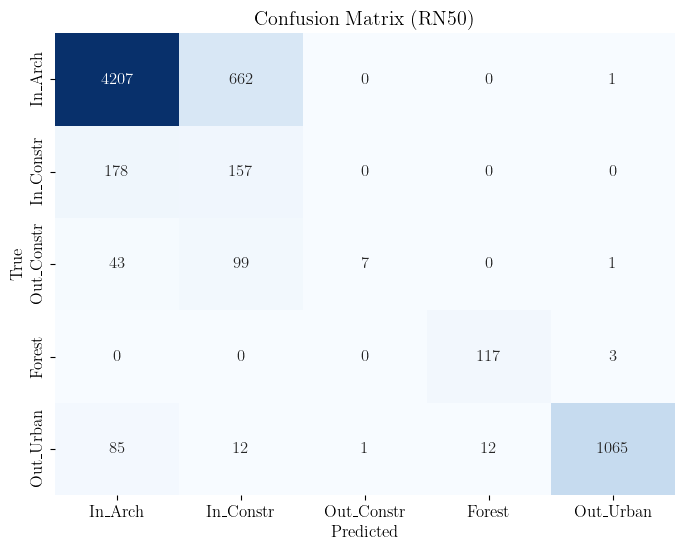

In [14]:
# define specific sequence of class labels
class_sequence = ['In_Arch', 'In_Constr', 'Out_Constr', 'Forest', 'Out_Urban']

label_encoder = LabelEncoder()
df['Class3new_encoded'] = label_encoder.fit_transform(df['ClassTrue'])
df['y_pred_encoded'] = label_encoder.transform(df['y_pred'])
label_encoder.fit(class_sequence)

# compute the confusion matrix
cm = confusion_matrix(df['Class3new_encoded'], df['y_pred_encoded'])

# get the indices of class_sequence
class_indices = label_encoder.transform(class_sequence)

# reorder the confusion matrix
cm_ordered = cm[np.ix_(class_indices, class_indices)]

figname = f'Confusion Matrix ({vision_arch})'
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
    "font.size": 12
})

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ordered, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_sequence, yticklabels=class_sequence)

plt.title(figname)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(evaluationFolder / figname,dpi = 600, bbox_inches='tight')
plt.show()